In [2]:
import json
import os
import pickle
import shutil

import matplotlib.pyplot as plt
import numpy as np
from cv2 import cv2
from skimage import color, draw, util

from smurves import surgebinder  # Генерация линий

from skimage import io
from sklearn.preprocessing import MinMaxScaler

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.python.keras import Sequential, layers, metrics
import tensorflow.python.keras.backend as K
from tensorflow.python.keras.preprocessing.image import DirectoryIterator

# Генерация данных (генерация линий)

In [3]:
IMG_SIZE = 100

In [333]:
def get_sin(row_range):
    sin_periods = [30, 20, 10, 6]
    
    magnitude = np.random.randint(10, 30)
    rad = np.random.choice(sin_periods)
    
    values = np.sin(row_range / rad) * magnitude + magnitude
    return values.astype('uint8')

def gen_background(size, config: dict):
    img = np.zeros((size, size), dtype='uint8') + 255
    row_range = np.arange(size)
    
    if config.get('simple', False):
        return img

    if config.get('sin_v', True):
        for i in range(np.random.randint(0, 3)):
            img -= get_sin(row_range)
    
    if config.get('sin_h', True):
        for i in range(np.random.randint(0, 3)):
            img -= get_sin(row_range).reshape((size, 1))
    
    if config.get('noize', True) and np.random.rand() > 0.5:
            img_noize = img.astype('float32') + (np.random.random((size, size)) - 0.5) * 20
            img = np.clip(img_noize, 0, 255).astype('uint8')
    
    return img

def _get_curve(size, config: dict):
    x_start, y_start = np.random.randint(0, 60, 2)
    x_end = np.random.randint(x_start + 10, size, 1)
    y_end = np.random.randint(y_start + 10, size, 1)
    if config.get('type', 'curve') == 'curve':
        curves = surgebinder(n_curves = 1,
             x_interval = [float(x_start), float(x_end)],
             y_interval = [float(y_start), float(y_end)],
             n_measure = 100,
             direction_maximum = np.random.randint(1, 8),
             convergence_point = None,  # [0.001, 1.0],
             log_scale = False,
    #          change_range = [0.2, 0.8],
             start_force = None  # 0.01
            )
    else:
        x_list = np.repeat([x_start], y_end - y_start)
        y_list = np.arange(y_start, y_end)
        curves = [
            np.vstack((y_list, x_list)).T
        ]
    curve = np.unique(curves[0].astype('int32'), axis=0)
    return curve

def gen_img(size, config: dict):
    img = gen_background(size, config=config.get('background', {}))
    
    curve = _get_curve(size, config=config.get('curve', {}))
    img[curve[:, 0], curve[:, 1]] = np.random.randint(50, 150, curve.shape[0])
    
    return img, curve

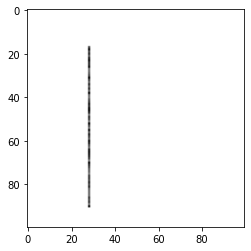

In [334]:
# img, _ = gen_img(100, config={'background': {'simple': True}, 'curve': {'type': 'curve'}})
img, _ = gen_img(100, config={'background': {'simple': True}, 'curve': {'type': 'line'}})
plt.imshow(img, cmap='gray')

In [311]:
DATASET_FOLDER = 'data/lines_vertical'

In [ ]:
def update_dir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    
    os.makedirs(dir_name)
    return dir_name

def update_labels(index_new, label_new: dict, path='', to_remove=False):
    assert path, 'path is empty'
    try:
        with open(path, 'rb') as f:
            data: dict = pickle.load(f)
    except:
        data = {}

    if to_remove:
        data = {}
    
    if label_new is not None:
        data[index_new] = label_new
        with open(path, 'wb') as f:
            pickle.dump(data, f)

def gen_images(n_count=4000):
    folder = DATASET_FOLDER
    path_label = f'{folder}/labels.pkl'
    train_dir = update_dir(f'{folder}/train/0')
    valid_dir = update_dir(f'{folder}/validation/0')
    test_dir  = update_dir(f'{folder}/test/0')
    
    update_labels(None, None, path=path_label, to_remove=True)  # remove exist labels
    
    for i in range(n_count):
        if i > 0 and i % 500 == 0:
            print(f'Iteration: {i}')

        img, curve = gen_img(size=IMG_SIZE, config={'background': {'simple': True}, 'curve': {'type': 'line'}})
        
        rand_num = np.random.rand()
        if rand_num < 0.5:
            img_path = f'{train_dir}/{i}.png'
        elif rand_num < 0.8:
            img_path = f'{valid_dir}/{i}.png'
        else:
            img_path = f'{test_dir}/{i}.png'
        
        update_labels(i, curve, path=path_label)
        plt.imsave(img_path, img, cmap=plt.cm.gray)

In [335]:
gen_images(n_count=5000)

# Создание модели

In [336]:
BATCH_SIZE = 8
CLASS_MODE = 'input'
TARGET_SIZE = 100

In [337]:
desc = {}
def get_desc(file_name: str):
    global desc
    
    img_number = int(file_name[:-4].rsplit('\\')[-1])

    if not desc:
        with open(f'{DATASET_FOLDER}/labels.pkl', 'rb') as f:
            desc = pickle.load(f)

    return desc[img_number]

In [338]:
class PicturesIterator(DirectoryIterator):
    def __init__(self, directory, generator, *args, **kwargs):
        target_size = kwargs.get('target_size', TARGET_SIZE)
        super(PicturesIterator, self).__init__(directory, generator, *args,
                                               target_size=(target_size, target_size),
                                               class_mode=CLASS_MODE,
                                               color_mode='grayscale',
                                               batch_size=BATCH_SIZE,
                                               **kwargs)

    def _get_batches_of_transformed_samples(self, index_array):
        train, test = super(PicturesIterator, self)._get_batches_of_transformed_samples(index_array)
        test[:, :, :, 0] = 0

        for i, index in enumerate(index_array):
            curve = get_desc(file_name=self.filenames[index])

            test[i, curve[:, 0], curve[:, 1]] = 1

        return train, test

In [339]:
def prepare_data(folder=DATASET_FOLDER):
    datagen_tr = ImageDataGenerator(rescale=1. / 255, horizontal_flip=False)
    datagen_test = ImageDataGenerator(rescale=1. / 255)

    # load and iterate training dataset
    train_it = PicturesIterator(f'{folder}/train', datagen_tr)

    # load and iterate validation dataset
    val_it = PicturesIterator(f'{folder}/validation', datagen_test)

    # load and iterate test dataset
    test_it = PicturesIterator(f'{folder}/test', datagen_test)

    return train_it, val_it, test_it

Found 2471 images belonging to 1 classes.
Found 1473 images belonging to 1 classes.
Found 1056 images belonging to 1 classes.


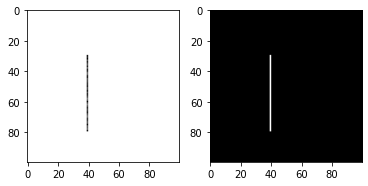

In [349]:
data = prepare_data(folder=DATASET_FOLDER)
tmp = next(data[1])

_, axes = plt.subplots(1, 2)
axes[0].imshow(tmp[0][0].reshape((100, 100)), cmap='gray')
axes[1].imshow(tmp[1][0].reshape((100, 100)), cmap='gray')
plt.show()

Как результат:
- 1 слой не тянет от слова совсем
- 2 слоя прекрасно спраляются с работой (32 (3x3), 32 (3x3) но с разводами

In [437]:
checkpoint_path = 'training/cp_{}.ckpt'.format(DATASET_FOLDER.split('/')[-1])

def define_model(print_summary=False, load_weights=False):
    model = Sequential()
    model.add(layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
#     model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
#     model.add(layers.Conv2D(1, (3, 3), padding='same', activation='relu'))   # Output
    model.add(layers.Dense(1, activation='relu'))

    model.build(input_shape=(BATCH_SIZE, TARGET_SIZE, TARGET_SIZE, 1))

    if print_summary:
        model.summary()

#     metrics for visual analysis
    model.compile(loss=K.binary_crossentropy, optimizer='adam')

    if load_weights:
        model.load_weights(checkpoint_path)

    return model

def fit_model(model, data, epochs=5):
    train_it, val_it, test_it = data

    cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            verbose=1)

    history = model.fit(train_it, epochs=epochs, validation_data=val_it,
                        callbacks=[cp_callback])

#     loss = model.evaluate(test_it, steps=24)
    return history

In [438]:
define_model(load_weights=False, print_summary=True)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (8, 100, 100, 1)          10        
_________________________________________________________________
dense_7 (Dense)              (8, 100, 100, 1)          2         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [390]:
data = prepare_data(folder=DATASET_FOLDER)

Found 2471 images belonging to 1 classes.
Found 1473 images belonging to 1 classes.
Found 1056 images belonging to 1 classes.


In [391]:
model = define_model(load_weights=False, print_summary=True)
history = fit_model(model, data, epochs=10)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (8, 100, 100, 16)         160       
_________________________________________________________________
dense_4 (Dense)              (8, 100, 100, 1)          17        
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no at

In [ ]:
# model = define_model(load_weights=True)

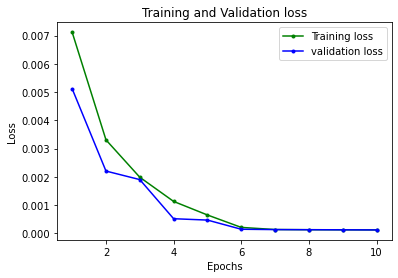

In [392]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss_train) + 1)
plt.plot(epochs, loss_train, '.-g', label='Training loss')
plt.plot(epochs, loss_val, '.-b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [393]:
test_1 = next(data[-1])
test_1_prediction = model.predict(test_1[0])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


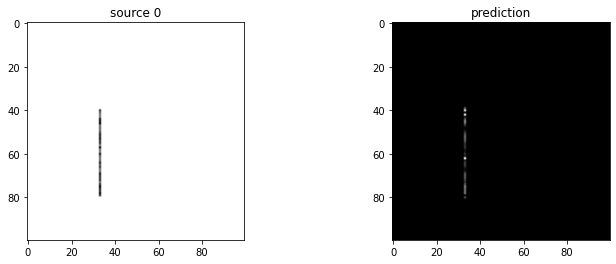

In [394]:
for i in range(len(test_1_prediction)):
    img_test_source = test_1[0][i].reshape((100, 100))
    img_out = test_1_prediction[i].reshape((100, 100))
    
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].imshow((img_test_source * 255).astype('uint8'), cmap='gray')
    axes[0].set_title(f'source {i}')
    
    axes[1].imshow((img_out * 255).astype('uint8'), cmap='gray')
    axes[1].set_title('prediction')
    
    plt.show()
    break

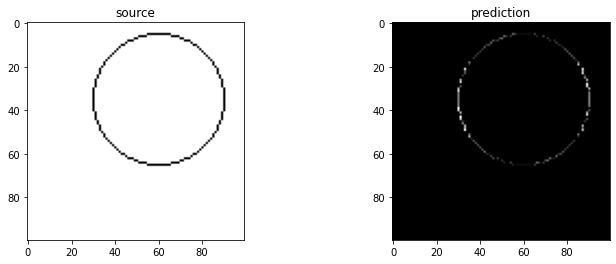

In [330]:
img = np.zeros((100, 100), dtype='uint8') + 255
circle = draw.circle_perimeter(35, 60, 30)
img[circle] = 0
img_out = model.predict(util.img_as_float(img).reshape(1, 100, 100, 1))

_, axes = plt.subplots(1, 2, figsize=(12, 4))
    
axes[0].imshow(img, cmap='gray')
axes[0].set_title('source')

axes[1].imshow((img_out.reshape((100, 100)) * 255).astype('uint8'), cmap='gray')
axes[1].set_title('prediction')
plt.show()

# Анализ весов и причин плохой работы

In [172]:
def minmax(arr):
    min_val = arr.min(axis=None)
    return (arr - min_val) / (arr.max(axis=None) - min_val)

#### Для одного слоя

In [331]:
layer_weight = {}
for name, w in zip(['first', 'relu1', 'out', 'relu3'], model.weights):
    print(name, w.shape)  # , w.numpy)
    layer_weight[name] = w.numpy()
# with open('data/weights_{}.pkl'.format(), 'wb') as f:
#     pickle.dump(layer_weight, f)

first (3, 3, 1, 4)
relu1 (4,)
out (3, 3, 4, 1)
relu3 (1,)


#### Для двух слоёв

In [770]:
layer_weight = {}
for name, w in zip(['first', 'relu1', 'second', 'relu2', 'out', 'relu3'], model.weights):
    print(name, w.shape)  # , w.numpy)
    layer_weight[name] = w.numpy()
# with open('data/lines_layers_weights.pkl', 'wb') as f:
#     pickle.dump(layer_weight, f)

first (3, 3, 1, 32)
relu1 (32,)
second (5, 5, 32, 64)
relu2 (64,)
out (3, 3, 64, 128)
relu3 (128,)


#### Отображение весов первого слоя

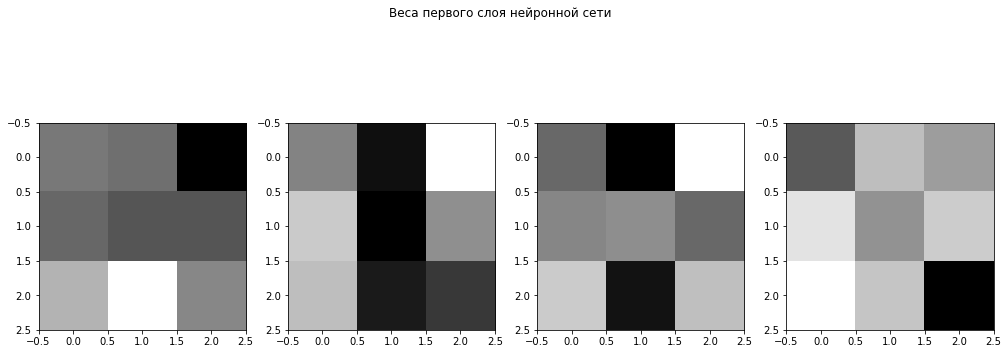

In [332]:
w1 = layer_weight['first'].reshape((3, 3, layer_weight['first'].shape[-1]))
n_cols = min(w1.shape[-1], 8)
n_rows = w1.shape[-1] // n_cols

_, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6))
if not isinstance(axes[0], (list, np.ndarray)):
    axes = [axes]
# print(isinstance(axes[0], ()), axes)
for i in range(n_rows):
    for j in range(n_cols):
        w_index = i * n_cols + j
#         w_img = MinMaxScaler().fit_transform(w1[:, :, w_index])
        w_img = minmax(w1[:, :, w_index])
        
        axes[i][j].imshow((w_img * 255).astype('uint8'), cmap='gray')
        
plt.suptitle('Веса первого слоя нейронной сети')
plt.tight_layout()
plt.show()

In [805]:
np.multiply(img[0:3, 0:3].reshape((3, 3, 1)), layer_weight['first'].reshape((3, 3, 32))).shape

(3, 3, 32)

In [ ]:
def conv_imitation(img: np.ndarray, weights: np.ndarray):
    size, window_size = img.shape[0]
     = weights.shape[0]
    res = img.copy().reshape((size, size, weights.shape[-1]))
    for i in range(1, size):
        for j in range(1, size):
            img_i = img[i-1: i+2, j-1:j+2]
#             for i_w in range(weights.shape[-1])
            

In [789]:
img = color.rgb2gray(io.imread('data/lines_noize/train/0/6.png'))

In [783]:
img / 255. * layer_weight['first']

ValueError: operands could not be broadcast together with shapes (100,100,4) (3,3,1,32) 

In [427]:
output = np.array([
    [0, 1, 0],
    [0, 0.9, 0],
    [0, 1, 0],
], dtype='float32')

target = np.array([
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
], dtype='float32')

In [428]:
K.binary_crossentropy(target, output)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.1053604,  0.       ],
       [ 0.       ,  0.       , -0.       ]], dtype=float32)>